In [1]:
from pathlib import Path
import pandas as pd
import sys
import numpy as np
import torch
import random
import os

import warnings
warnings.filterwarnings("ignore")

def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU 
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [3]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from collections import Counter

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [4]:
result = pd.read_csv('./Test_AD_results_endtoend.csv')

In [5]:
anomaly_score = result['score']
ground_truth = result['true_label']

### Best F1

In [93]:
# Best F1
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 10000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5504, F1: 0.8352, Precision: 0.7192, Recall: 0.9959


In [94]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(0, 378, 4, 968)

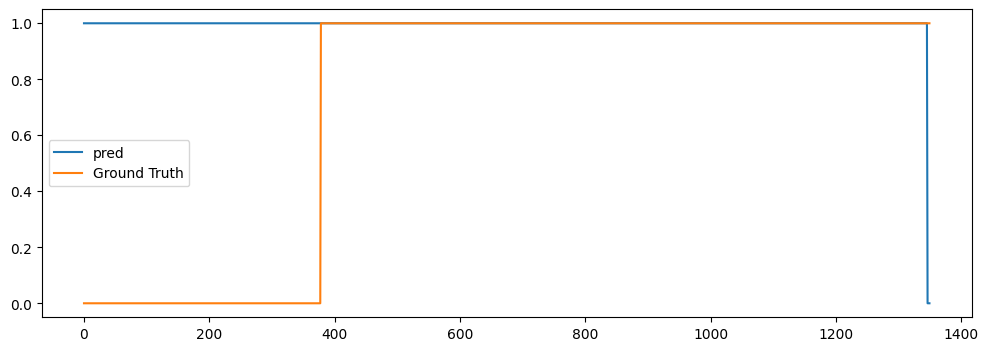

In [95]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

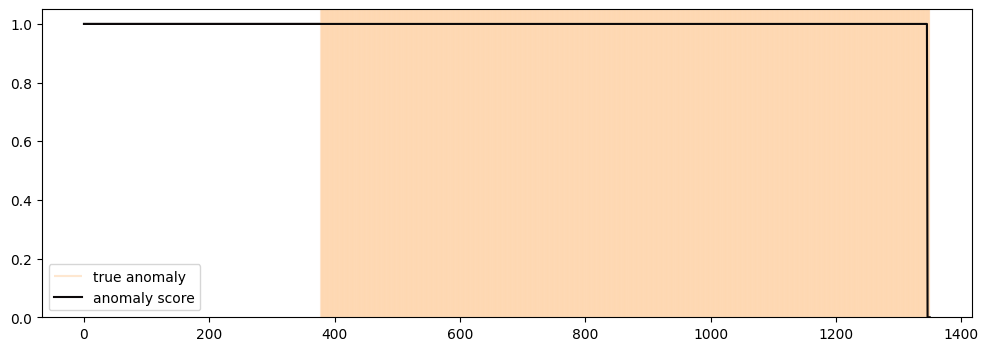

In [96]:
check_graph(pred, np.array(ground_truth))
plt.show()

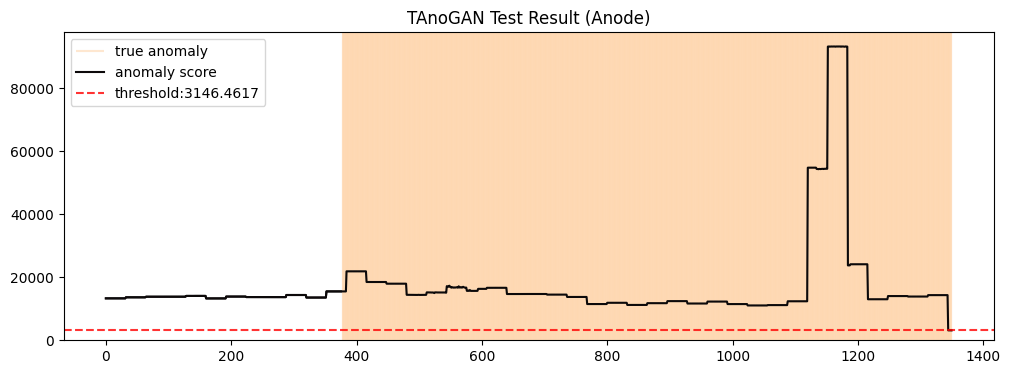

In [98]:
check_graph(np.array(anomaly_score), ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Anode)')
plt.show()

In [67]:
bead_counter = []
for i in range(len(pred)//54):
    bead_counter.append(dict(Counter(pred[i*54: (i+1)*54])))
print(bead_counter)

[{1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 53, 0: 1}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}]


### Best Precision

In [7]:
result

,score,true_label
0,180.352066,0.0
1,212.830338,0.0
2,230.232071,0.0
3,235.405533,0.0
4,232.245163,0.0
...,...,...
146849,275.122314,1.0
146850,285.218323,1.0
146851,284.393127,1.0
146852,287.534515,1.0


In [8]:
# Best Precision
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bp_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 1000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5048, F1: 0.1007, Precision: 0.7769, Recall: 0.0538


In [9]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(39220, 1638, 100291, 5705)

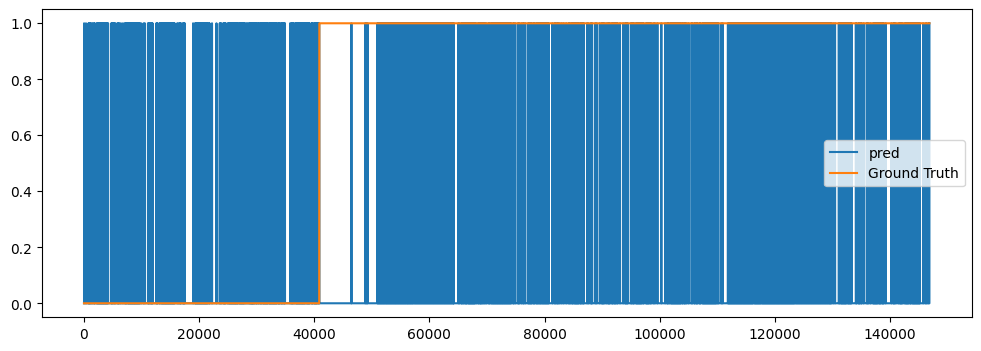

In [10]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

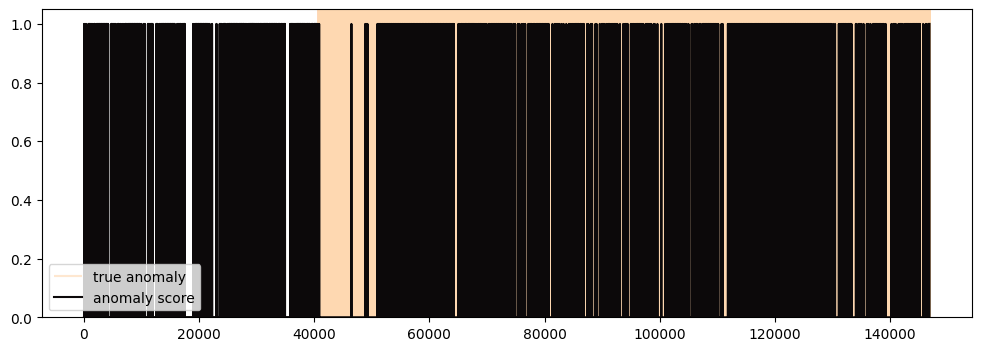

In [11]:
check_graph(pred, np.array(ground_truth))
plt.show()

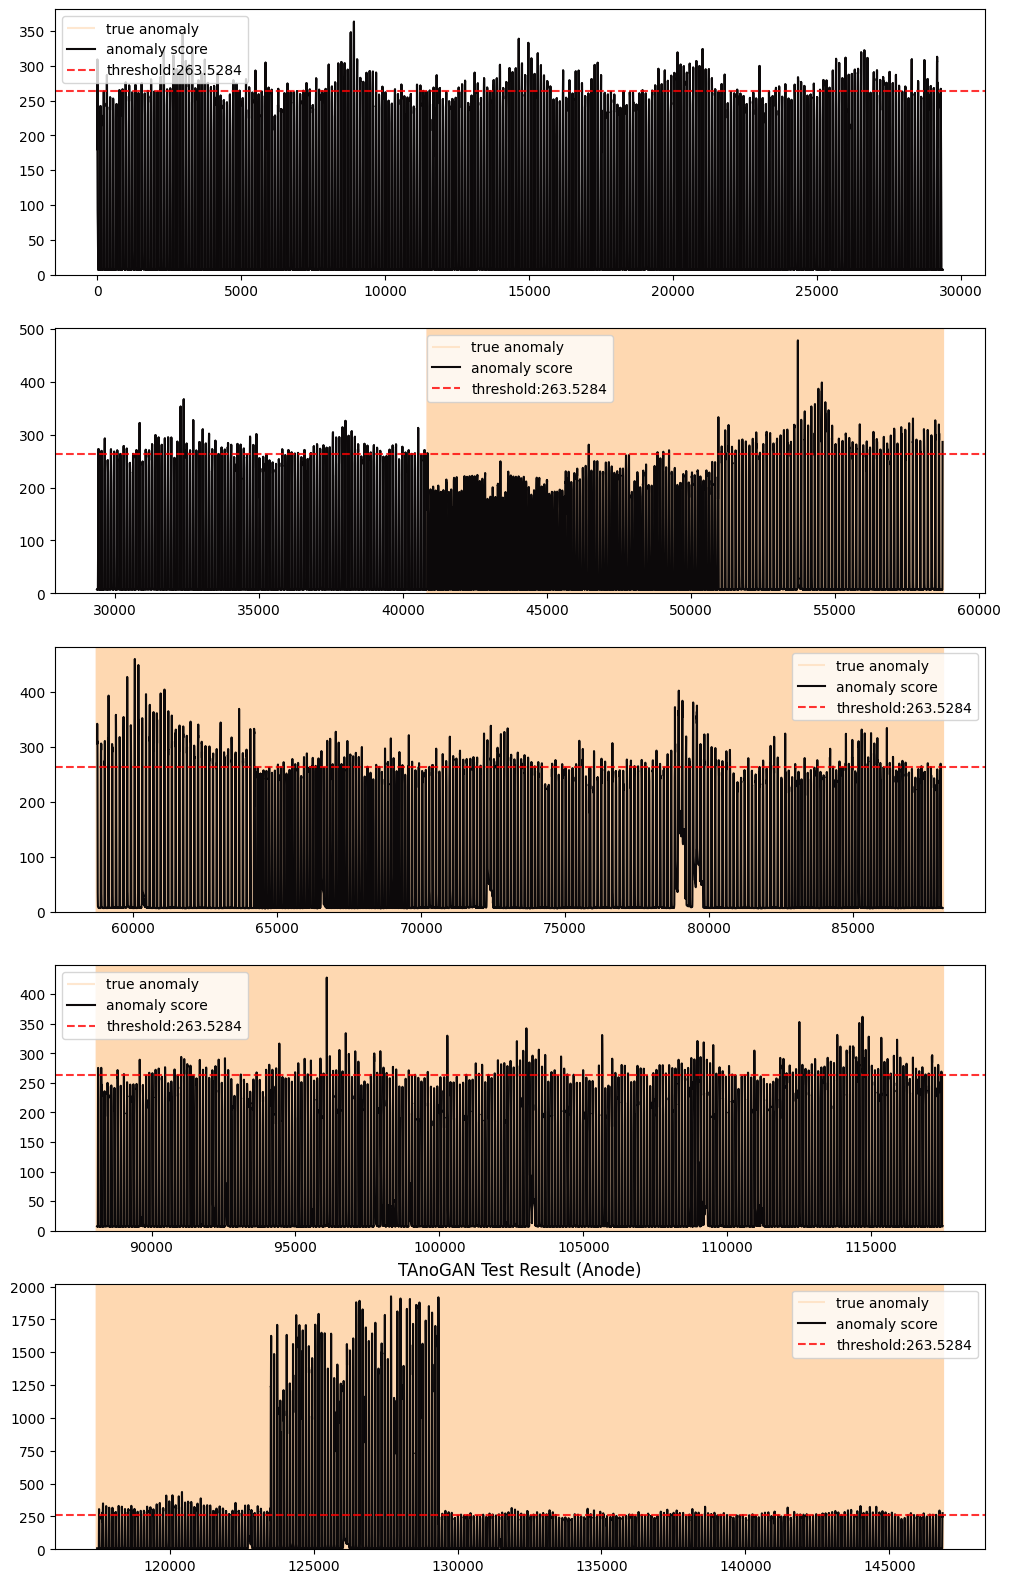

In [15]:
check_graph(np.array(anomaly_score), ground_truth,5,threshold)
plt.title('TAnoGAN Test Result (Anode)')
plt.show()

In [73]:
bead_counter = []
for i in range(len(pred)//54):
    bead_counter.append(dict(Counter(pred[i*54: (i+1)*54])))
print(bead_counter)

[{0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {1: 54}, {1: 54}, {0: 53, 1: 1}, {0: 52, 1: 2}, {1: 54}, {1: 2, 0: 52}, {0: 52, 1: 2}, {0: 54}, {0: 48, 1: 6}, {0: 39, 1: 15}, {1: 19, 0: 35}, {0: 53, 1: 1}, {0: 53, 1: 1}, {0: 52, 1: 2}, {1: 54}, {0: 52, 1: 2}, {0: 53, 1: 1}, {0: 52, 1: 2}]


In [86]:
abnormal_index = pd.DataFrame(bead_counter)[[1]].fillna(0).astype(int)
abnormal_index.columns = ['Abnormal']
abnormal_index.to_csv('Beads_Abnormal_count(TAnoGAN_Anode).csv', index = True)

### Threshold Sensitivity

In [ ]:
thres = []
f1_ = []
prec = []
recall_ = []
precision_thres = []

for th in np.linspace(float(min(result['score'])), float(max(result['score'])),10000):

    thres.append(th)
    f1_.append(f1)
    prec.append(precision)
    recall_.append(recall)

    f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], th, 100, False)

    if precision >= 0.9:
        precision_thres.append(th)

    print(f'F1: {f1:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}')
    
metrics = pd.DataFrame([thres, f1_, prec, recall_]).T
metrics.columns = ['threshold', 'f1', 'precision', 'recall']

In [86]:
# Threshold when Precision > 0.9

pred = (anomaly_score>precision_thres[0]).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

f1, precision, recall, _, _, _, _, auroc, _ =  calc_seq(result['score'], result['true_label'], precision_thres[0], 100, False)

print(f'AUROC: {auroc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.6340, F1: 0.6022, Precision: 0.9033, Recall: 0.4516


Text(0.5, 0.01, 'Threshold')

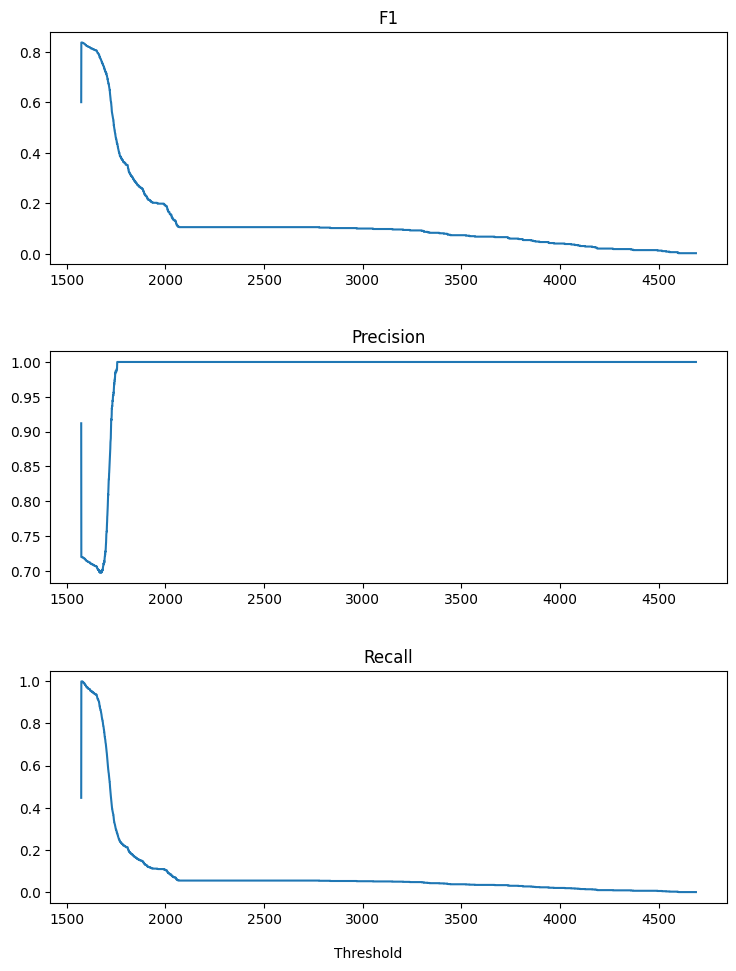

In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(metrics['threshold'])
y1 = np.array(metrics['f1'])
y2 = np.array(metrics['precision'])
y3 = np.array(metrics['recall'])

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot the data on each subplot
axs[0].plot(x, y1)
axs[0].set_title('F1')
axs[1].plot(x, y2)
axs[1].set_title('Precision')
axs[2].plot(x, y3)
axs[2].set_title('Recall')

# Add a common x-axis label and adjust the spacing between subplots
fig.tight_layout(pad=3.0)
fig.text(0.5, 0.01, 'Threshold', ha='center')

## Modelling

In [6]:
from extract_rule_based_features import ExtractFeatures, detect_bead

In [7]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'

    start = bead_array[0,0]
    end = bead_array[-1,1]
    data = data[start:end]

    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

In [8]:
def slice_end_to_end(path):

    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])

    start = bead_array[0,0]
    end = bead_array[-1,1]

    data = data[start:end]
    data['laser_active']=0
    data['bead_num'] = 0

    for i in range(len(bead_array)):
        data.loc[bead_array[i][0]:bead_array[i][1],'laser_active']=1
        data.loc[bead_array[i][0]:bead_array[i][1], 'bead_num'] = i+1

    return data, bead_array

In [4]:
def slice_bead_data(path, set_bead_100=False, set_end_to_end=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_end_to_end:
        if not set_bead_100:
            total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
        else:
            total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
        
        if 'Abnormal' in path:
            total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
        
        else:
            total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

        if not set_bead_100:
            for i in range(1, len(bead_array)):
                bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
                bead_data['bead_num'] = str(i)
                if 'Abnormal' in path:
                    bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
                
                else:
                    bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                    
                total_data = pd.concat([total_data, bead_data])

        else:
            for i in range(1, len(bead_array)):
                bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
                bead_data['bead_num'] = str(i)
                if 'Abnormal' in path:
                    bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
                
                else:
                    bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                    
                total_data = pd.concat([total_data, bead_data])
                    
        return total_data

In [ ]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])

data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])


for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]), set_bead_100=False, set_end_to_end=True)    
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]), set_bead_100=False, set_end_to_end=True)    
    Anode_Test = pd.concat([Anode_Test, bead_i])

In [ ]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])

data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num','laser_active','stamp'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num','laser_active','stamp'])

for i in range(num_train_dataset):

    bead_i, bead_array = slice_end_to_end(str(data_folder_list[i]))    
    if i == 0:
        train_bead_array_np = bead_array
    else:
        train_bead_array_np = np.concatenate([train_bead_array_np, bead_array])

    bead_i['stamp'] = i
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i, bead_array = slice_end_to_end(str(data_folder_list[i]))        
    if i == 0:
        test_bead_array_np = bead_array
    else:
        test_bead_array_np = np.concatenate([test_bead_array_np, bead_array])

    bead_i['stamp'] = i
    Anode_Test = pd.concat([Anode_Test, bead_i])

In [110]:
size = (len(Anode_Test)-25)//5+1
temp = Anode_Test.reset_index(drop=True)

In [6]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'

    start = bead_array[0,0]
    end = bead_array[-1,1]
    data = data[start:end]

    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

In [156]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])

data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','laser_active','bead_num','stamp'])

In [ ]:
def slice_end_to_end(path):
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]

    bead_array = detect_bead(data['LO'])

    start = bead_array[0,0]
    end = bead_array[-1,1]
    data = data[start:end]

    data['bead_num'] = 0
    data['laser_active'] = 0

    for i in range(len(bead_array)):
        data.loc[bead_array[i][0]:bead_array[i][1],'laser_active'] = 1
        data.loc[bead_array[i][0]:bead_array[i][1],'bead_num'] = int(i+1)

    return data

for i in range(num_train_dataset):
    bead_i = slice_end_to_end(str(data_folder_list[i]))    
    bead_i['stamp'] = int(i+1)
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_end_to_end(str(data_folder_list[i]))
    bead_i['stamp'] = int(i+1)
    Anode_Test = pd.concat([Anode_Test, bead_i])


# for i in range(num_train_dataset):
#     bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
#     Anode_Train = pd.concat([Anode_Train, bead_i])

# for i in range(num_train_dataset, len(data_folder_list)):
#     bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
#     Anode_Test = pd.concat([Anode_Test, bead_i])

In [158]:
test_temp = Anode_Test.copy().reset_index(drop=True)

In [159]:
len(test_temp['stamp'].unique())

25

In [160]:
total_window = (len(test_temp)-25)//5+1

bead_index = []
bead_stamp = []
bead_id = []

for i in range(total_window):
    if sum(test_temp.loc[i*5:i*5+24,'laser_active'])==25:
        bead_index.append(i)
        bead_stamp.append(test_temp.loc[i*5,'stamp'])
        bead_id.append(test_temp.loc[i*5,'bead_num'])

In [161]:
active_beads = result.loc[bead_index]
active_beads['stamp'] = bead_stamp
active_beads['beads_id'] = bead_id

In [152]:
active_beads.reset_index(drop=True, inplace = True)

In [195]:
beads_window_mean_df = active_beads.groupby(['stamp','beads_id'])[['score','true_label']].mean().reset_index().sort_values(by=['stamp','beads_id'])

In [183]:
anomaly_score = beads_window_mean_df['score']
ground_truth = beads_window_mean_df['true_label']

In [186]:
# Best Precision
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bp_search(
                                                                score = anomaly_score,
                                                                label = ground_truth,
                                                                start = min(anomaly_score), 
                                                                end = np.percentile(anomaly_score, 95), 
                                                                step_num = 10000,
                                                                K = 100, 
                                                                verbose = False
                                                                )

print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.4987, F1: 0.2343, Precision: 1.0000, Recall: 0.1327


In [187]:
pred = (anomaly_score>threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(ground_truth, pred).ravel()
(tn, fp, fn, tp)

(378, 0, 843, 129)

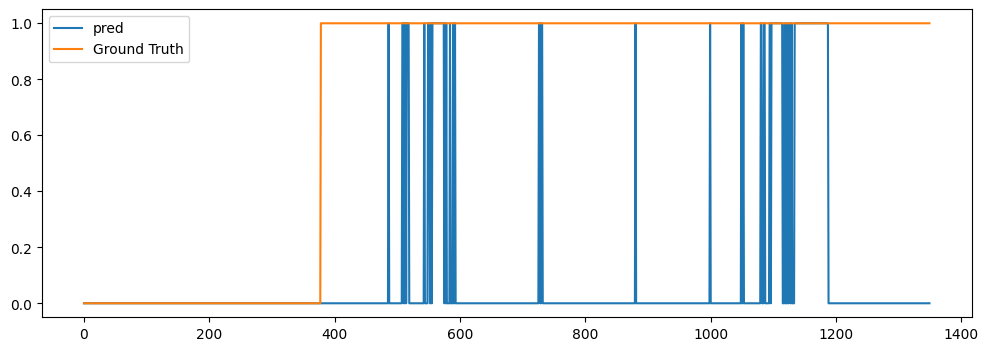

In [190]:
fig = plt.figure(figsize=(12, 4))
plt.plot(pred, label='pred')
plt.plot(ground_truth, label='Ground Truth')
plt.legend()
plt.show()

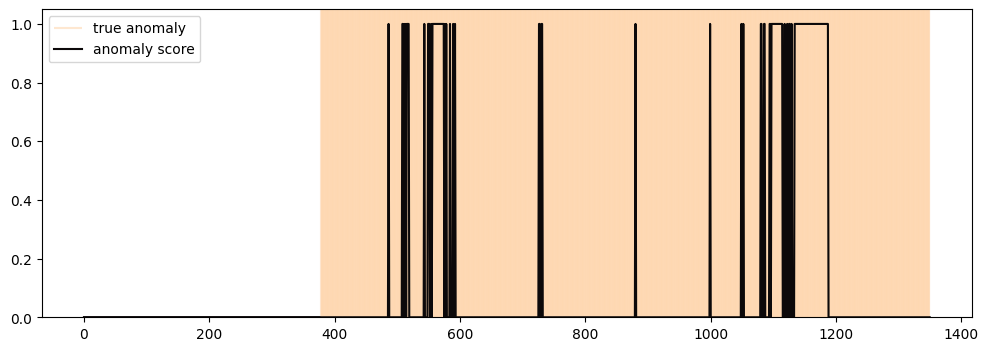

In [191]:
check_graph(pred, np.array(ground_truth))
plt.show()

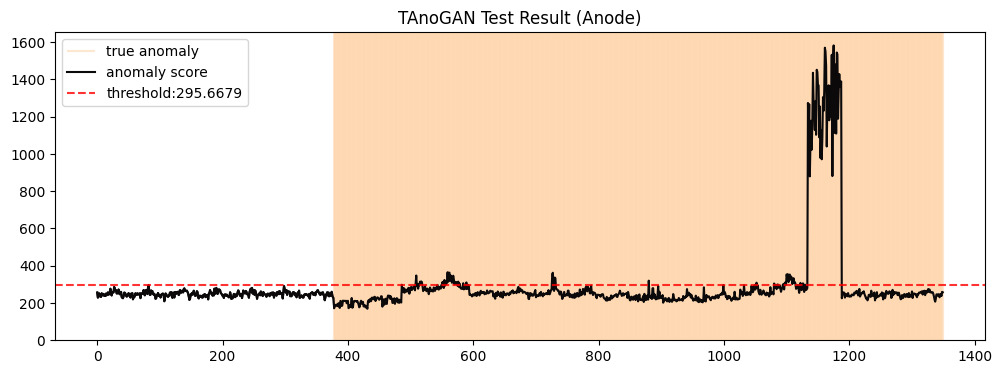

In [194]:
check_graph(np.array(anomaly_score), ground_truth,1,threshold)
plt.title('TAnoGAN Test Result (Anode)')
plt.show()

In [18]:
window_size = 25
step_size = 5

# Train Sample size
print((len(Anode_Train)-window_size)//step_size + 1)
print((len(Anode_Test)-window_size)//step_size + 1)

163428

In [19]:
Anode_Train.to_csv('./Anode_train_processed.csv', index = False)
Anode_Test.to_csv('./Anode_test_processed.csv', index = False)

In [8]:
Anode_Train = pd.read_csv('./Anode_train_processed.csv')
Anode_Test = pd.read_csv('./Anode_test_processed.csv')

In [9]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-2547b852-4d6e-15b9-897e-ff698a3ef4c9)


In [10]:
# import gc
# import torch

# gc.collect()
# torch.cuda.empty_cache()

In [11]:
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler

class create_dataset(Dataset):
    
    def __init__(
                self, train_data, test_data, 
                feature_names : list, 
                window_length: int = 100, step_size: int = 100, 
                mode:str = 'train'
                ):
        
        super(create_dataset, self).__init__()

        self.window_length = window_length
        self.step_size = step_size

        train_label = train_data['label'].values
        test_label = test_data['label'].values

        self.scaler = StandardScaler()

        train_data = self.scaler.fit_transform(train_data[feature_names])
        test_data = self.scaler.transform(test_data[feature_names].values)

        self.data = train_data if mode == 'train' else test_data
        self.label = train_label if mode == 'train' else test_label

        self.data = np.float32(self.data)
        self.label = np.float32(self.label)
        
    def __len__(self):
        
        return (self.data.shape[0] - self.window_length) // self.step_size + 1
    
    def __getitem__(self, idx):
        
        idx = idx * self.step_size

        xx = self.data[idx:idx+self.window_length]
        yy = self.label[idx:idx+self.window_length]
                
        return xx, yy

In [12]:
import torch.nn as nn
import torch

class Dis(nn.Module):
    def __init__(self, in_dim, hidden_size):
        super(Dis, self).__init__()

        self.in_dim = in_dim
        self.hidden_size = hidden_size

        self.layer1 = nn.LSTM(in_dim, hidden_size=hidden_size, num_layers = 1, batch_first = True)
        self.linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())

    def forward(self, x, h_0, c_0):

        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        output = out.reshape(batch_size * window_size, self.hidden_size)

        output = self.linear(output).reshape(batch_size, window_size, 1)

        return output, out

In [13]:
class Gen(nn.Module):

    def __init__(self, in_dim, window_size):

        super(Gen,self).__init__()

        self.in_dim = in_dim
        self.window_size = window_size
        self.layer1 = nn.LSTM(in_dim, hidden_size = 32, num_layers = 1, batch_first = True) #stack of 3 LSTM with different hidden size
        self.layer2 = nn.LSTM(32, hidden_size = 64, num_layers = 1, batch_first = True)
        self.layer3 = nn.LSTM(64, hidden_size = 128, num_layers = 1, batch_first = True)
        self.FC = nn.Sequential(nn.Linear(128, in_dim), nn.Tanh())

    def forward(self, x, h_0, c_0):
        
        batch_size, window_size = x.size(0), x.size(1)
        out, _ = self.layer1(x, (h_0, c_0))
        out, _ = self.layer2(out)
        out, _ = self.layer3(out)

        FC_input = out.reshape(batch_size * window_size, 128)

        output = self.FC(FC_input)

        output = output.reshape(batch_size, window_size, self.in_dim)

        return output, out

In [14]:
window_size = 25
slide = 5

feature_names = ['LO','BR',	'NIR','VIS']

train_dataset = create_dataset(Anode_Train, Anode_Test, feature_names,
                          window_size,slide,'train')

test_dataset = create_dataset(Anode_Train, Anode_Test, feature_names,
                          window_size,slide,'test')

train_loader = DataLoader(train_dataset, 128, shuffle = True)

test_loader = DataLoader(test_dataset, 1, shuffle = False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch_seed(77)

gen_model = Gen(in_dim=4, window_size = window_size)
gen_model.to(device)
dis_model = Dis(in_dim=4, hidden_size = window_size)
dis_model.to(device)

criterion = torch.nn.BCELoss()
optimizer_g = torch.optim.Adam(params=gen_model.parameters(), lr = 1e-3)
optimizer_d = torch.optim.Adam(params=dis_model.parameters(), lr = 1e-3)

In [15]:
len(train_loader.dataset)

163428

In [16]:
import torch
import torch.nn as nn
import logging
import wandb
import time
import pdb
import torch.nn.init as init
from torch.autograd import Variable
from collections import OrderedDict
import os
import json

_logger = logging.getLogger('train')

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(gen, dis, train_loader, 
    optimizer_G, optimizer_D, criterion, device,
    log_interval
    ):

    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    acc_d_real_m = AverageMeter()
    acc_d_fake_m = AverageMeter()
    acc_g_m = AverageMeter()

    losses_d_real_m = AverageMeter()
    losses_d_fake_m = AverageMeter()
    losses_g_m = AverageMeter()
    losses_d_m = AverageMeter()

    end = time.time()

    dis.train()
    gen.train()

    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

    for idx, (xx, _) in enumerate(train_loader):

        # Train Discriminator
        
        batch_size, window_size, in_dim = xx.size(0), xx.size(1), xx.size(2)

        optimizer_D.zero_grad()

        label = torch.ones((batch_size, window_size, 1)).to(device)
        label_size = label.flatten().shape[0]

        xx = xx.to(device)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        output,_ = dis(xx, h_0, c_0)
        
        loss_D_real = criterion(output, label)
        loss_D_real.backward()

        losses_d_real_m.update(loss_D_real.item())

        optimizer_D.step()

        preds = torch.round(output).detach().cpu()

        acc_d_real_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)

        output, _ = dis(fake.detach(), h_0, c_0)

        label = torch.zeros((batch_size, window_size, 1)).to(device)
        
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()

        losses_d_fake_m.update(loss_d_fake.item())
        loss_dis = loss_d_fake + loss_D_real
        optimizer_D.step()

        losses_d_m.update(loss_dis.item())

        preds = torch.round(output).detach().cpu()

        acc_d_fake_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        # Train Generator
        optimizer_G.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,window_size,in_dim),mean=0,std=0.1)).to(device)
        fake, _ = gen(noise, h_g_0, c_g_0)
        
        label = torch.ones((batch_size, window_size, 1)).to(device)
        output, _ = dis(fake, h_0, c_0)

        loss_g = criterion(output, label)
        loss_g.backward()

        losses_g_m.update(loss_g.item())

        optimizer_G.step()

        preds = torch.round(output).detach().cpu()
        acc_g_m.update(label.detach().cpu().eq(preds).sum().item()/label_size, n=label_size)

        if idx % log_interval == 0 and idx != 0:

            _logger.info('TRAIN Iteration: [{:>4d}/{}] \n'
                        'Loss D Real: {losses_d_real.val:>6.4f} ({losses_d_real.avg:>6.4f}) '
                        'Acc D Real: {acc_d_real.avg:.3%} \n'
                        'Loss D Fake: {losses_d_fake.val:>6.4f} ({losses_d_fake.avg:>6.4f}) '
                        'Acc D Fake: {acc_d_fake.avg:.3%} \n'
                        'Loss D: {loss_dis:.3f} \n'
                        'Loss G: {losses_g.val:>6.4f} ({losses_g.avg:>6.4f}) '
                        'Acc G: {acc_g.avg:.3%} \n'
                        'LR: {lr:.3e} \n'.format(
                        idx+1, len(train_loader), 
                        losses_d_real = losses_d_real_m,
                        acc_d_real = acc_d_real_m,
                        losses_d_fake = losses_d_fake_m,
                        acc_d_fake = acc_d_fake_m,
                        loss_dis = loss_dis.item(),
                        losses_g = losses_g_m,
                        acc_g = acc_g_m,
                        lr    = optimizer_D.param_groups[0]['lr'],
                        )
            )

        end = time.time()

    return OrderedDict([('acc_d_real',acc_d_real_m.avg), ('loss_d_real',losses_d_real_m.avg),
                        ('acc_d_fake',acc_d_fake_m.avg), ('loss_d_real',losses_d_fake_m.avg),
                        ('acc_g',acc_g_m.avg), ('loss_g',losses_g_m.avg), ('loss_d', losses_d_m.avg)
                        ])

In [17]:
from tqdm import tqdm
epochs = 20

for epoch in tqdm(range(epochs)):

    train_metrics = train(
                        gen = gen_model, dis = dis_model, train_loader = train_loader, optimizer_G = optimizer_g,
                        optimizer_D = optimizer_d, criterion = criterion, device = device, log_interval = 1
                        )
    
    print(train_metrics)

    metrics = OrderedDict(lr=optimizer_d.param_groups[0]['lr'])
    metrics.update([('train_' + k, v) for k, v in train_metrics.items()])

  5%|▌         | 1/20 [00:18<05:53, 18.59s/it]

OrderedDict([('acc_d_real', 0.9181163570501994), ('loss_d_real', 0.7808668391024963), ('acc_d_fake', 0.3660050909268914), ('acc_g', 0.6173568788702058), ('loss_g', 0.7309339126993551), ('loss_d', 1.168805571977478)])


 10%|█         | 2/20 [00:38<05:48, 19.34s/it]

OrderedDict([('acc_d_real', 0.9610294441588957), ('loss_d_real', 0.7497655629481574), ('acc_d_fake', 0.4987529676677191), ('acc_g', 0.48287710796191596), ('loss_g', 1.148619035671676), ('loss_d', 1.0188419594718967)])


 15%|█▌        | 3/20 [00:59<05:41, 20.11s/it]

OrderedDict([('acc_d_real', 0.9808510169615978), ('loss_d_real', 0.9384518679269329), ('acc_d_fake', 0.08698754191448221), ('acc_g', 0.9053263822600778), ('loss_g', 0.566906799176473), ('loss_d', 1.3180150981283598)])


 20%|██        | 4/20 [01:20<05:29, 20.57s/it]

OrderedDict([('acc_d_real', 0.9679680348532688), ('loss_d_real', 0.9675717049963136), ('acc_d_fake', 0.1431338571113885), ('acc_g', 0.8451073255500894), ('loss_g', 0.5729640329850308), ('loss_d', 1.3259925436674849)])


 25%|██▌       | 5/20 [01:41<05:07, 20.47s/it]

OrderedDict([('acc_d_real', 0.9908938492791933), ('loss_d_real', 0.9659890391533508), ('acc_d_fake', 0.022744450155420124), ('acc_g', 0.9736625302885674), ('loss_g', 0.49336803645572347), ('loss_d', 1.3522928953637532)])


 30%|███       | 6/20 [02:01<04:46, 20.44s/it]

OrderedDict([('acc_d_real', 0.9354967325060577), ('loss_d_real', 0.7619122414555789), ('acc_d_fake', 0.35781604131482975), ('acc_g', 0.6282742247350516), ('loss_g', 0.9543274450134092), ('loss_d', 1.107742467847016)])


 35%|███▌      | 7/20 [02:21<04:23, 20.28s/it]

OrderedDict([('acc_d_real', 0.9730342413784664), ('loss_d_real', 0.35264496953345503), ('acc_d_fake', 0.8007957020828744), ('acc_g', 0.18975132780184545), ('loss_g', 2.5448052553852367), ('loss_d', 0.481181630799102)])


 40%|████      | 8/20 [02:42<04:04, 20.40s/it]

OrderedDict([('acc_d_real', 0.989129157794258), ('loss_d_real', 0.9485700797455892), ('acc_d_fake', 0.03412952492840884), ('acc_g', 0.9625006730792764), ('loss_g', 0.5139656405175395), ('loss_d', 1.3416005346862805)])


 45%|████▌     | 9/20 [03:02<03:43, 20.28s/it]

OrderedDict([('acc_d_real', 0.9925584355190054), ('loss_d_real', 0.9665602005685598), ('acc_d_fake', 0.038239469368774016), ('acc_g', 0.9551256822576303), ('loss_g', 0.5005223519557513), ('loss_d', 1.3470529525561918)])


 50%|█████     | 10/20 [03:22<03:23, 20.32s/it]

OrderedDict([('acc_d_real', 0.9683917076633135), ('loss_d_real', 0.41632415330038935), ('acc_d_fake', 0.7336152923611621), ('acc_g', 0.2532868296742296), ('loss_g', 2.9587223179399174), ('loss_d', 0.5714290047249667)])


 55%|█████▌    | 11/20 [03:42<03:01, 20.17s/it]

OrderedDict([('acc_d_real', 0.9639545243165186), ('loss_d_real', 0.7816352936889197), ('acc_d_fake', 0.2957921531194165), ('acc_g', 0.6990302763296375), ('loss_g', 1.127860253071449), ('loss_d', 1.1143460750241436)])


 60%|██████    | 12/20 [04:02<02:41, 20.18s/it]

OrderedDict([('acc_d_real', 0.9752556477470201), ('loss_d_real', 0.35256953306420297), ('acc_d_fake', 0.7575122989940525), ('acc_g', 0.23246689673740117), ('loss_g', 3.965298931885251), ('loss_d', 0.4937010090579348)])


 65%|██████▌   | 13/20 [04:22<02:21, 20.21s/it]

OrderedDict([('acc_d_real', 0.9813123822111266), ('loss_d_real', 0.9565543210660469), ('acc_d_fake', 0.0745695963971902), ('acc_g', 0.9186445407151773), ('loss_g', 0.5268675384688583), ('loss_d', 1.3400088048065277)])


 70%|███████   | 14/20 [04:42<02:01, 20.17s/it]

OrderedDict([('acc_d_real', 0.9930352204028685), ('loss_d_real', 0.9497189270675229), ('acc_d_fake', 0.025354773967741145), ('acc_g', 0.9686367085199599), ('loss_g', 0.5040400622874942), ('loss_d', 1.3373505057724735)])


 75%|███████▌  | 15/20 [05:03<01:41, 20.30s/it]

OrderedDict([('acc_d_real', 0.9857383067772965), ('loss_d_real', 0.9399191278821337), ('acc_d_fake', 0.04936803974839073), ('acc_g', 0.944707638837898), ('loss_g', 0.5170786861525725), ('loss_d', 1.3295162078824563)])


 80%|████████  | 16/20 [05:23<01:20, 20.18s/it]

OrderedDict([('acc_d_real', 0.9836219007758769), ('loss_d_real', 0.9685480436871737), ('acc_d_fake', 0.033059451256822574), ('acc_g', 0.9626149741782314), ('loss_g', 0.4986673754143267), ('loss_d', 1.3477134419869143)])


 85%|████████▌ | 17/20 [05:43<01:00, 20.12s/it]

OrderedDict([('acc_d_real', 0.9847091073745013), ('loss_d_real', 0.9302090570248938), ('acc_d_fake', 0.06412830114790612), ('acc_g', 0.9264397777614607), ('loss_g', 0.5288792037366421), ('loss_d', 1.3139820802743862)])


 90%|█████████ | 18/20 [06:03<00:40, 20.10s/it]

OrderedDict([('acc_d_real', 0.9779619159507551), ('loss_d_real', 0.9336024019152462), ('acc_d_fake', 0.08649778495729006), ('acc_g', 0.9061818048314855), ('loss_g', 0.562038095485632), ('loss_d', 1.308892462201294)])


 95%|█████████▌| 19/20 [06:23<00:20, 20.15s/it]

OrderedDict([('acc_d_real', 0.9685216731527033), ('loss_d_real', 0.8253282495805688), ('acc_d_fake', 0.28796558729226324), ('acc_g', 0.7063509312969626), ('loss_g', 1.0327627867191866), ('loss_d', 1.1421272529226407)])


100%|██████████| 20/20 [06:43<00:00, 20.19s/it]

OrderedDict([('acc_d_real', 0.9955760334826346), ('loss_d_real', 0.9411036636134844), ('acc_d_fake', 0.017778593631446262), ('acc_g', 0.9795552781653083), ('loss_g', 0.5073772304536033), ('loss_d', 1.3297776405290411)])


In [18]:
dis_loss_cand = train_metrics['loss_d']
gen_loss_cand = train_metrics['loss_g']

In [19]:
import torch
from torch.autograd import Variable
import torch.nn.init as init
import pandas as pd
import os
import logging
import pdb

_logger = logging.getLogger('Optimization')

def Anomaly_score(latent, fake, latent_interm, fake_interm, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(latent-fake)) # Residual Loss
    
    discrimination_loss = torch.sum(torch.abs(latent_interm-fake_interm)) # Discrimination loss

    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

def optimize(save_dir, dis, gen, test_loader, window_size, 
             in_dim, Lambda, iterations, device, log_interval,
             save_df: bool = False,
             batched: bool = False
             ):

    anomaly_score = []
    y_label = []
    #actual_obs = []
    test_anomaly_score = pd.DataFrame()

    dis.eval()
    gen.eval()

    torch.backends.cudnn.enabled = False
    
    for idx, (xx,yy) in enumerate(tqdm(test_loader)):

        y_label.append(yy[0][0].detach().item())
        #actual_obs.append(xx.flatten()[window_size-1].detach().item())

        xx = xx.to(device)
        batch_size = xx.size(0)

        h_0, c_0 = torch.zeros(1, batch_size, dis.hidden_size).to(device), torch.zeros(1, batch_size, dis.hidden_size).to(device)
        h_g_0, c_g_0 = torch.zeros(1, batch_size, 32).to(device), torch.zeros(1, batch_size, 32).to(device)

        z = Variable(init.normal(torch.zeros(batch_size, window_size, in_dim, device=device),mean = 0, std = 0.1),
                    requires_grad = True)

        z_optimizer =  torch.optim.Adam([z],lr = 0.01)
        
        _logger.info(f'\n Batch: {idx+1}/{len(test_loader)}')

        for iter in range(iterations):

            fake, _ = gen(z, h_g_0, c_g_0)
            _, x_feature = dis(xx, h_0, c_0) 
            _, G_z_feature = dis(fake, h_0, c_0) 

            loss = Anomaly_score(xx, fake, x_feature, G_z_feature, Lambda = Lambda)
            z_optimizer.zero_grad()
            loss.backward()
            z_optimizer.step()

        _logger.info('Batch [{}/{}]: Anomaly Score: {:.3f} label: {}'.format(idx+1, len(test_loader), loss.item(),yy[0][0].detach().item()))

        if batched:

            with torch.no_grad():
                for i in range(len(xx)):
                    h_0, c_0 = torch.zeros(1, 1, dis.hidden_size).to(device), torch.zeros(1, 1, dis.hidden_size).to(device)
                    h_g_0, c_g_0 = torch.zeros(1, 1, 32).to(device), torch.zeros(1, 1, 32).to(device)

                    fake, _ = gen(z[i].unsqueeze(0), h_g_0, c_g_0)
                    _, x_feature = dis(xx[i].unsqueeze(0), h_0, c_0) 

                    _, G_z_feature = dis(fake, h_0, c_0) 
                    
                    loss = Anomaly_score(xx[i].detach(), fake.detach(), x_feature.detach(), G_z_feature.detach(), Lambda = Lambda)
                
                    anomaly_score.append(loss.item())
        else:
            anomaly_score.append(loss.item())
                                                                             
    if save_df:
        test_anomaly_score['score'] = anomaly_score
        test_anomaly_score['true_label'] = y_label
        test_anomaly_score.to_csv(save_dir,index=False)

    return anomaly_score

In [20]:
save_dir = '/workspace/Project_LG_Welding_AD/src'
df_dir = os.path.join(save_dir,'Test_AD_results_endtoend.csv')

test_loader = DataLoader(test_dataset, 1, shuffle = False)

anomaly_score = optimize(
                        save_dir=df_dir,
                        dis=dis_model,gen = gen_model, 
                        test_loader = test_loader,
                        window_size= window_size,
                        in_dim = 4,
                        Lambda = 0.1,
                        iterations = 5,
                        device = device, 
                        log_interval = int(50/5),
                        save_df = True,
                        batched = False
                        )

100%|██████████| 146854/146854 [7:37:22<00:00,  5.35it/s]  
